# Draft: Trending WFS&C Data with WebbPSF

***

## Imports
 Describe the libraries we're using here. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *webbpsf* to use the webbpsf trending functions and library as an example
- *astropy* to use various astropy features such as units and time and open fits files
- *os* to use OS level system calls
- *matplotlib* to generate various plots and manipulate them


In [3]:
import webbpsf
import astropy
import astropy.units as u
from astropy.time import Time
import astropy.io.fits as fits
import os
import matplotlib.pyplot as plt
import matplotlib

## Introduction
The purpose of this notebook is to provide some examples of how to use the WebbPSF trending API for JWST WFS&C Data.  Code excerpts and text extracted from: https://webbpsf.readthedocs.io/en/latest/jwst_measured_opds.html

### Defining terms
For more information on JWST Acronyms and abbreviations please see: https://jwst-docs.stsci.edu/jwst-acronyms-and-abbreviations

For more information on JWST Wavefront Sensing and Control: https://jwst-docs.stsci.edu/jwst-observatory-hardware/jwst-wavefront-sensing-and-control

***

## Installing WebbPSF and required data files
Follow installation instructions on WebbPSF:
https://webbpsf.readthedocs.io/en/latest/installation.html

If you install via pip or manually, you must install the data files yourself.

Files containing such information as the JWST pupil shape, instrument throughputs, and aperture positions are distributed separately from WebbPSF. To run WebbPSF, you must download these files and tell WebbPSF where to find them using the WEBBPSF_PATH environment variable.

  1. Download the following file: [webbpsf-data-LATEST.tar](https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz) [approx. 70 MB]

  2. Untar webbpsf-data-LATEST.tar.gz into a directory of your choosing.

  3. Set the environment variable WEBBPSF_PATH to point to that directory. e.g.

## Download Data from MAST

The WFS&C Data is available in MAST: Barbara A. Mikulski Archive for Space Telescopes
The MAST Portal lets you search multiple collections of astronomical datasets all in one place. Use this tool to find astronomical data, publications, and images. [JWST WSS OPDs](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22WSSFILTERED%22%2C%22inputText%22%3A%5B%7B%22isDate%22%3Afalse%2C%22niceName%22%3A%22isRestricted%22%2C%22paramName%22%3A%22isRestricted%22%2C%22valString%22%3A%22%22%2C%22values%22%3A%5B%22false%22%5D%7D%5D%2C%22position%22%3A%22undefined%2C%20undefined%2C%20undefined%22%2C%22paramsService%22%3A%22Mast.Jwst.Filtered.Wss%22%2C%22title%22%3A%22WSS%3A%20%20Advanced%20Search%201%22%2C%22tooltip%22%3A%22%22%2C%22columns%22%3A%22*%22%7D)

WebbPSF uses Astroquery MAST API under the hood to retrieve the OPDs from MAST.  

Here's an example notebook that shows how to use MAST to download science data:
https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/JWST/download_by_program_id/download_by_program_id.ipynb 

WebbPSF does something similar under the hood but uses the service: 'Mast.Jwst.Filtered.Wss'
https://github.com/spacetelescope/webbpsf/blob/develop/webbpsf/mast_wss.py#L360

The API handles the transactions so you can download all of the data needed here:

In [4]:
opdtable = webbpsf.mast_wss.retrieve_mast_opd_table()
opdtable = webbpsf.mast_wss.deduplicate_opd_table(opdtable)
webbpsf.mast_wss.download_all_opds(opdtable)

WebbPSF provides various trending features.  Here's an example of how to get a monthly trending plot by specifying the year and the month:

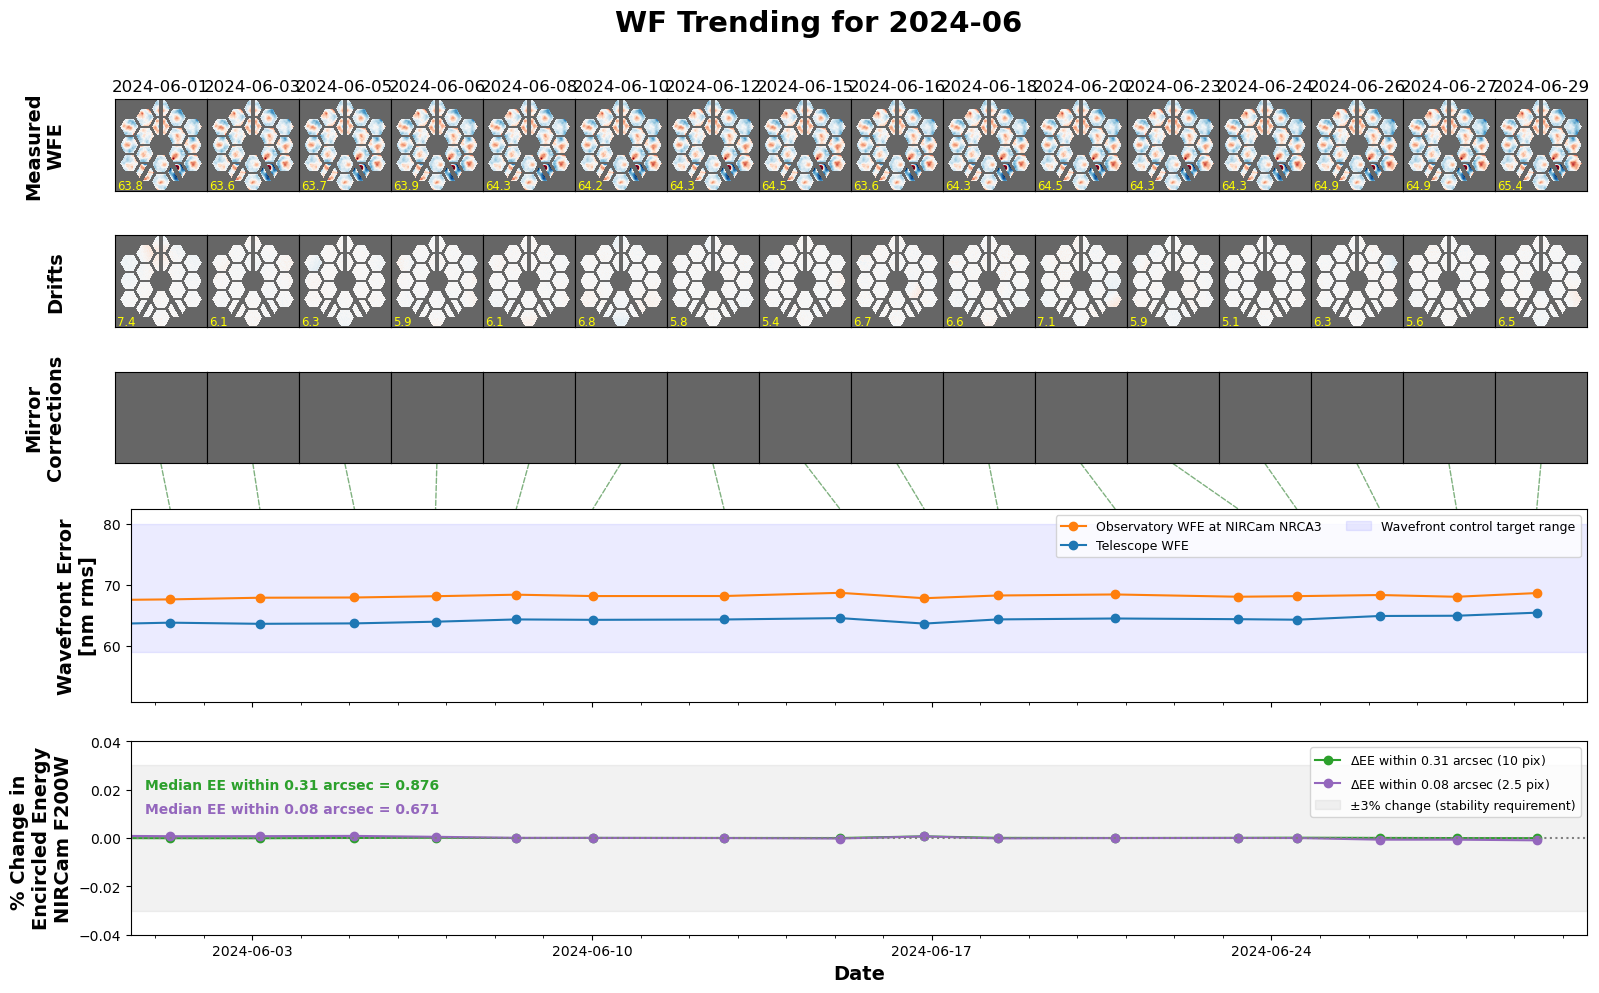

In [5]:
trend_table = webbpsf.trending.monthly_trending_plot(2024, 6, verbose=False)

The above figure shows:

Each wavefront sensing measurement throughout the specified month (first row)

The drift in wavefront between each two successive measurements (i.e. the changes arising in the telescope itself, without any ground commanding. Second row)

The mirror corrections applied (i.e. the result of mirror move commands sent from the ground. Third row)

Plots of the wavefront RMS value over time, for both the OTE wavefront only (i.e. the waveront quality from the telescope delivered to the NIRCam sensing field point) and the total observatory wavefront (i.e. the sum of telescope and instrument contributions to the wavefront).

Computed values for the encircled energy within radii of 2.5 pixels and 10 pixels, and their variation over time.

In the above plot for 2022 July, we can see that the wavefront was generally stable (very little change from one meaurement to the next, but a few individual mirror tilt events can be seen for instance in the July 4 and July 6 sensing). A wavefront correction was applied on July 8. Then the July 12 wavefront sensing revealed a larger wing tilt event affecting the several segments on the left (-V2) wing. This was corrected in the July 15 wavefront sensing and control observation, and after that the telescope remained stable throughout the rest of that month’s wavefront sensing.

The monthly_trending_plot function automatically saves the plot as a PDF to the current working directory, with filenames like “wf_trending_2022-08.pdf'”

The function also returns a table with information summarizing the available WFS measurements, WFE levels, and computed PSF encircle energies. This can be used to help understand how much the photometry in your observation is affected by PSF changes at a given time.

In [6]:
# Convert astropy table to Pandas dataframe and look at some general statistics
df = trend_table.to_pandas()
df.describe()

,RMS WFE (OTE+SI),RMS WFE (OTE only),EE(2.5 pix),EE(10pix)
count,17.000000,17.000000,17.000000,17.000000
mean,68.091277,64.223757,0.671290,0.876454
std,0.333000,0.534019,0.000391,0.000153
min,67.391475,63.370955,0.670566,0.876324
25%,67.894384,63.770912,0.671100,0.876402
50%,68.113330,64.291932,0.671224,0.876425
75%,68.297569,64.453260,0.671647,0.876457
max,68.657811,65.406447,0.671923,0.877014


## Wavefront time series and histrogram plots

Other functions can provide views of wavefront changes over even longer timescales. We can retrieve a table of all available OPDs and plot the measurements over time:

In [11]:
opdtable = webbpsf.mast_wss.retrieve_mast_opd_table()
opdtable = webbpsf.mast_wss.deduplicate_opd_table(opdtable)
webbpsf.mast_wss.download_all_opds(opdtable)

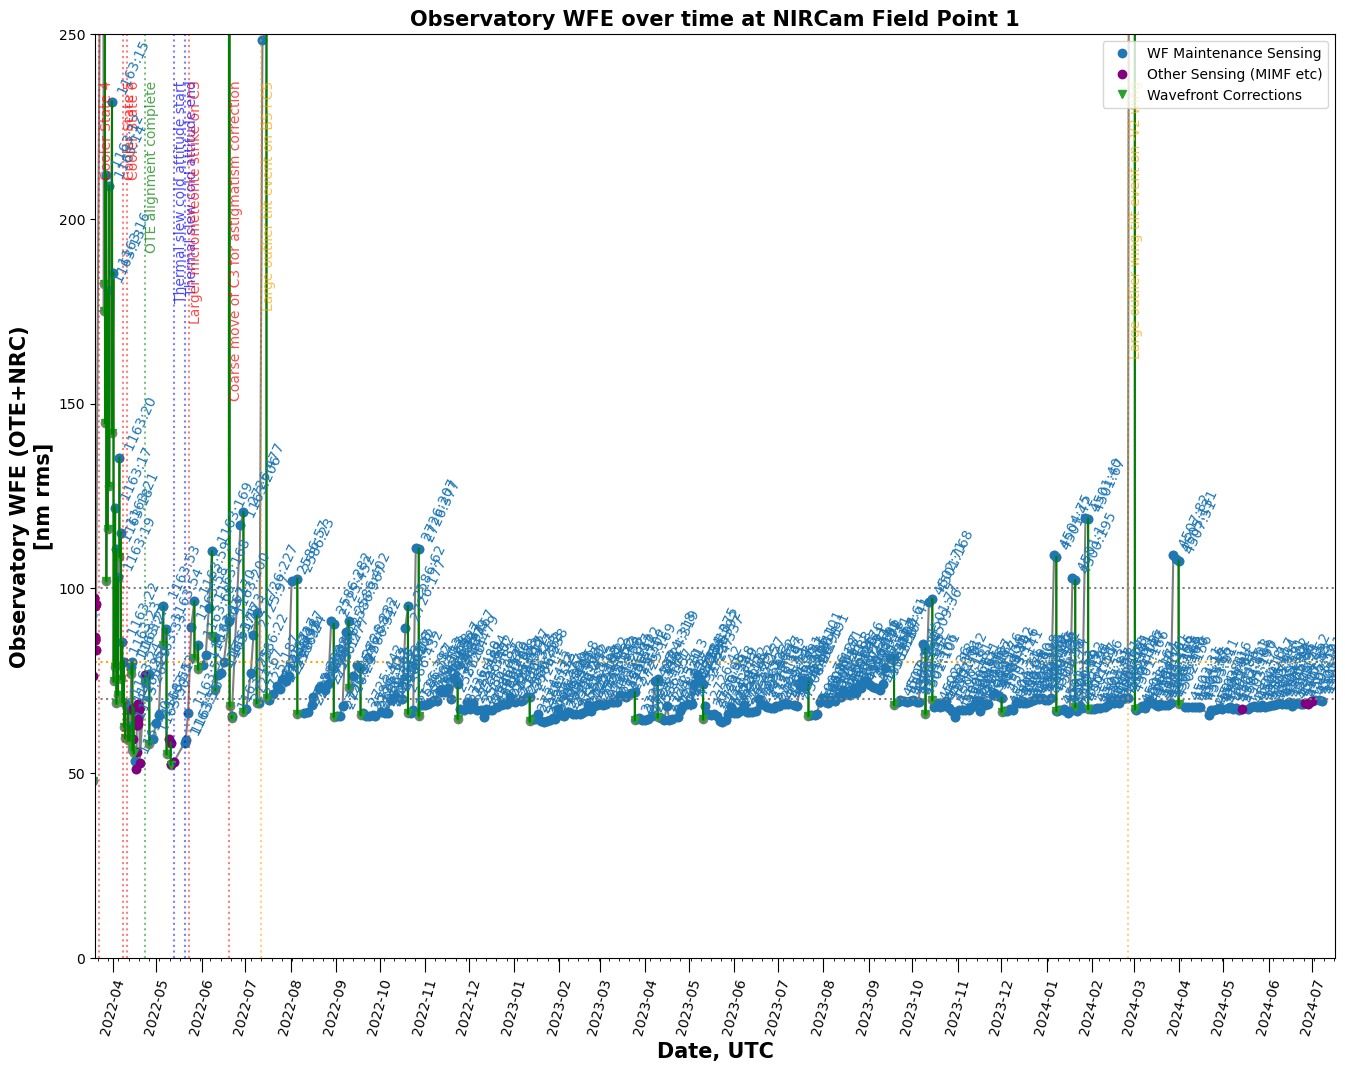

In [12]:
webbpsf.trending.wavefront_time_series_plot(opdtable)

The above shows wavefront drifts and corrections from around the middle of OTE commissioning to the early part of Cycle 1. Rapid drifts and corrections in early March are from the MIRI cryocooler gradually cooling the observatory, until reaching thermal stability in mid April.

Occasional increases in wavefront error from mirror tilts and corrections can be seen in subsequent months. There was an especially large tilt event on July 12, which was corrected on July 15.

We can also plot all measured wavefront drifts over specified time periods.

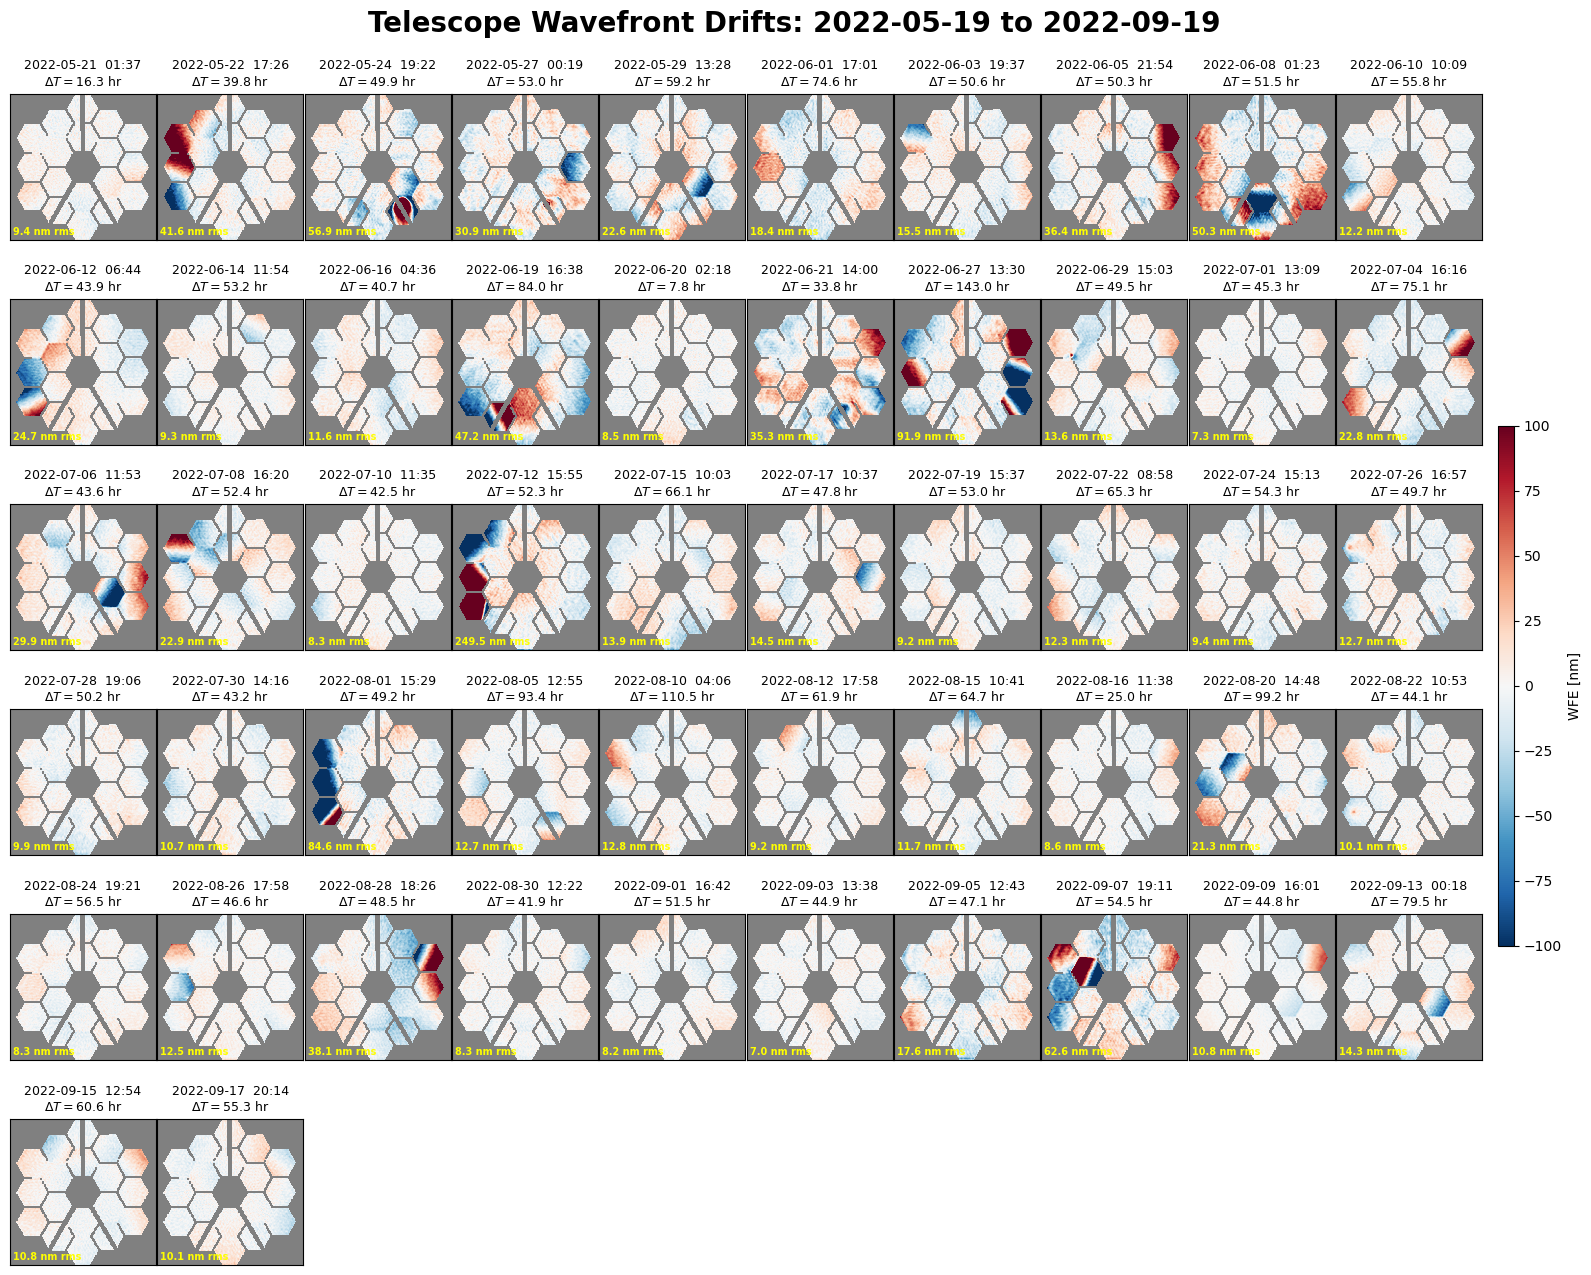

In [13]:
start_time =  astropy.time.Time('2022-05-19T00:00:00')
end_time = astropy.time.Time('2022-09-19T00:00:00')

webbpsf.trending.wavefront_drift_plots(opdtable, start_time=start_time, end_time=end_time, n_per_row=10)

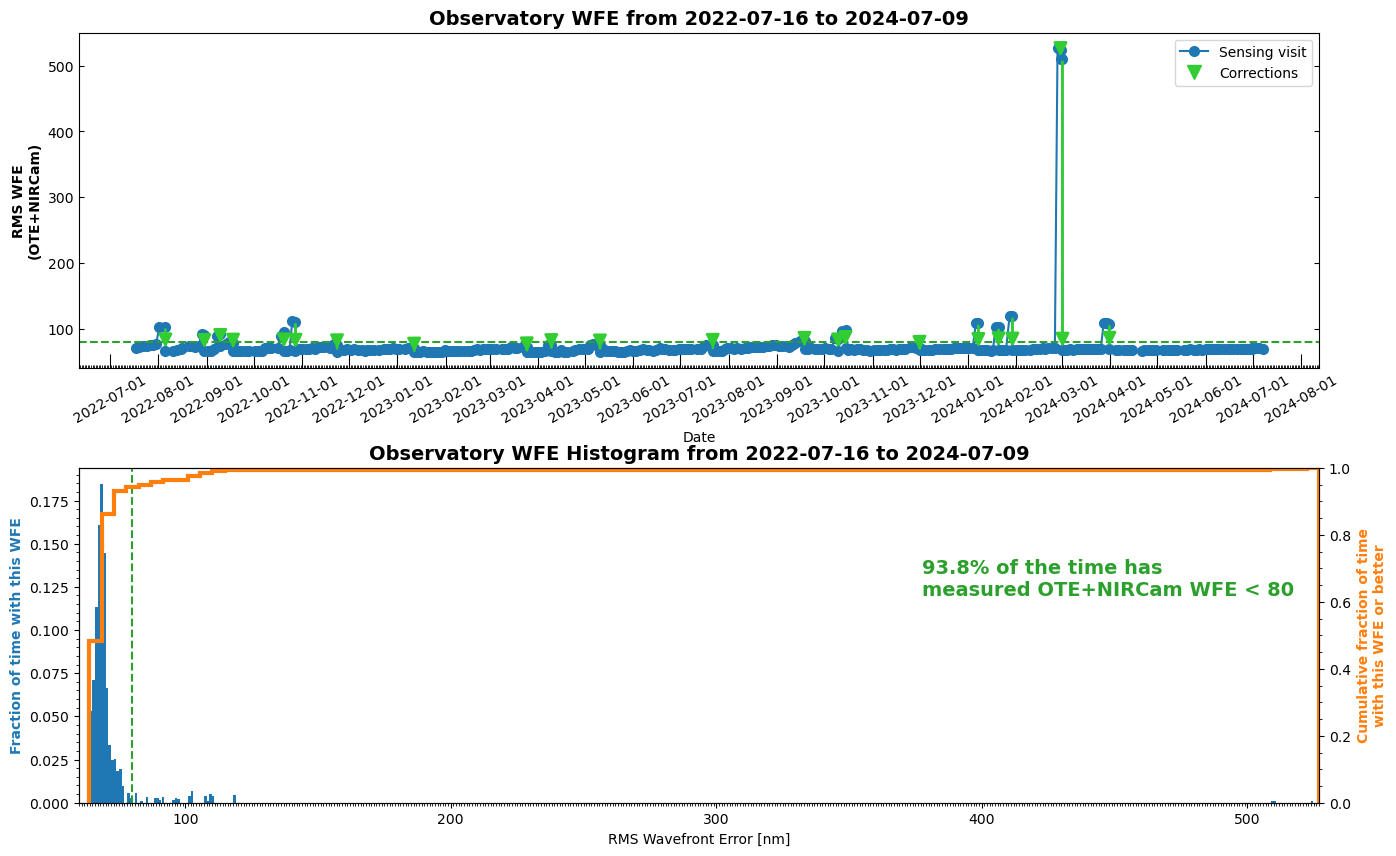

In [24]:
start_time =  astropy.time.Time('2022-07-16')
webbpsf.trending.wfe_histogram_plot(opdtable, start_date=start_time, thresh=80, mark_corrections='arrows')

The above plot shows the wavefront error evolution over the first part of Cycle 1, starting after the ERO release on July 12 and continuing up to present (as of 2022 Dec 13, during the “First Science with JWST” conference). You can see the occasional larger tilt events which are subsequently detected and corrected. It appears possible that the frequency of the larger events may be decreasing over time.

## Show Wavefront Sensing Trends around a science program

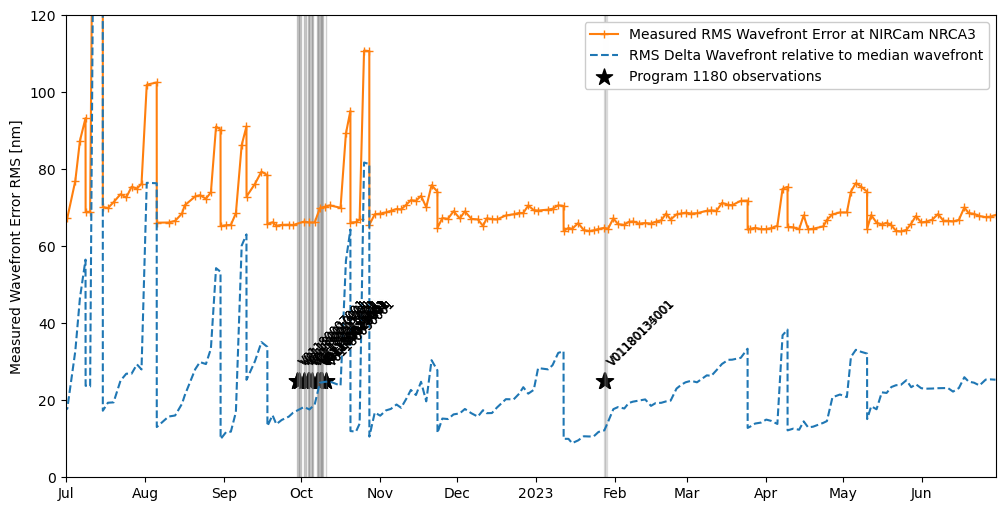

In [7]:
webbpsf.trending.show_wfs_during_program(1180, start_date='2022-07-01', end_date = '2023-06-30')

The stars with text labels and gray vertical lines indicate the times of all observations in that program. (There’s a lot of observations in October so the labels are a bit hard to read in this case.) We can see that, while the telescope had occasional periods of higher wavefront error, all of the JADES observations happened with the telescope wavefront error around its typical value.

The orange line shows the measured total wavefront RMS for each sensing; the blue line shows the RMS difference at each time relative to the median wavefront. In this case, all the JADES observations happened with no more than about 20 nm rms wavefront differences relative to the mean; this is lambda/100 at 2 microns, for instance, which leads to quite stable PSFs.

## Exercises
Most notebooks are trying to convey _some_ information to their reader. It's often a good idea, if possible, to include in the notebook something where there is not an included answer so that the reader can cement in their mind how whatever it is they were supposed to learn from that notebook. If you do have exercise(s), be sure to leave a blank code cell underneath to show the user that it's meant for them to try it out right there. You may also want to include a "solutions" notebook next to your main notebook for the user to look at after they have finished their attempt.

In [13]:
## Extract the RMS WFE from the OPD FITS header file 
## TODO: convert this to do pandas apply function
rmses = []
for row in opdtable:
    if os.path.isfile(row['fileName']) is False:
        full_file_path = os.path.join(webbpsf.utils.get_webbpsf_data_path(), 'MAST_JWST_WSS_OPDs', row['fileName'])
    else:
        full_file_path = row['fileName']
    if 'rms_wfe' not in opdtable.colnames:
        rmses.append(fits.getheader(full_file_path, ext=1)['RMS_WFE'])

In [10]:
df = opdtable.to_pandas()
df['rms_wfe'] = rmses
df['rms_wfe'] = df['rms_wfe'] * 1000

In [12]:
df['rms_wfe'].describe()

count    509.000000
mean      81.834257
std       56.566212
min       47.903500
25%       66.942900
50%       68.721000
75%       73.823200
max      536.800000
Name: rms_wfe, dtype: float64

<Axes: xlabel='date'>

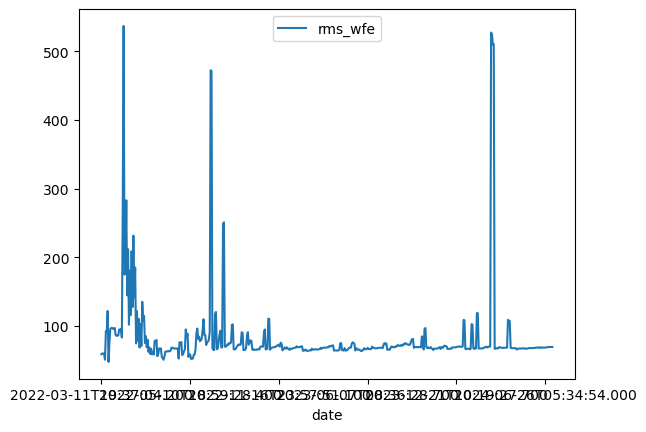

In [14]:
# TODO: fix the x-axis so it shows the dates better
df.plot(x='date', y='rms_wfe') 

## Aditional Resources
While this isn't always necessary, sometimes you want to provide some more resources for the reader who wants to learn something beyond what's in the notebook. Sometimes these don't exist, but if they do, it's good to put them at the end to give the reader somewhere else to go. Usually a list of links using markdown bullet-plus-link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/exo/ExoMast/html/exomast.html)

## About this notebook
Let the world know who the author of this great notebook is! If possible/appropriate, include a contact email address for users who might need support (e.g. archive@stsci.edu)

**Author:** Trey Kulp, WSS SW Developer.  
**Updated On:** YYYY-MM-DD

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 